In [1]:
import os
import math
import h5py
import pandas as pd
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import KMeans
import cv2 as cv
import imutils
from imutils import perspective
from imutils import contours
from PIL import Image

from scipy import fftpack
from scipy import ndimage
from scipy.integrate import quad

In [2]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [3]:
def removePeriodicNoise(xbicData,colSt,colEd):
    xbicData_fft = fftpack.fft2(xbicData)
    fft_new=xbicData_fft.copy()
    fft_new[:,colSt:colEd]=0
    xbic_new=fftpack.ifft2(fft_new).real
    return xbicData_fft,xbic_new

In [4]:
def plotXRFmaps(data,mapType,colorRange):
    plt.figure()
    a=plt.imshow(data,cmap=plt.cm.get_cmap(mapType))
    if colorRange is not None:
            plt.cm.ScalarMappable.set_clim(a,vmin=colorRange[0],vmax=colorRange[1])
    print(plt.cm.ScalarMappable.get_clim(a))

In [5]:
def attenuationCorr(x, t_Au, alpha, beta, lamda_i_Au, lamda_i_psk,
                    lamda_o_elm_psk, lamda_o_elm_Au):

    attn_i_Au = np.exp(-t_Au / (lamda_i_Au * (math.cos(math.radians(alpha)))))
    attn_o_elm_Au = np.exp(-t_Au / (lamda_o_elm_Au *
                                    (math.cos(math.radians(beta)))))
    return attn_i_Au * np.exp(
        -x / (lamda_i_psk *
              (math.cos(math.radians(alpha))))) * attn_o_elm_Au * np.exp(
                  -x / (lamda_o_elm_psk * (math.cos(math.radians(beta)))))

In [6]:
def incidentAbsorption(x, t_Au, alpha, lamda_i_Au, lamda_i_psk):
    attn_i_Au = np.exp(-t_Au / (lamda_i_Au * (math.cos(math.radians(alpha)))))
    return attn_i_Au * np.exp(-x / (lamda_i_psk *
                                    (math.cos(math.radians(alpha)))))

In [7]:
def collectionProfile(x,ld):
    return np.exp(-x/ld)

In [8]:
def resizeMap(elmMap,org_stepsize,new_stepsize):
    org_pix = elmMap.shape
    org_um = np.dot(org_pix, abs(org_stepsize))
    new_pix = np.divide(org_um, abs(new_stepsize)).astype(int)
    resizemap = cv.resize(elmMap, (new_pix[0], new_pix[1]))
    return resizemap

In [9]:
def selectMap(elmMap,xbicMap):
    xbicsize = xbicMap.shape
    xrfsize = elmMap.shape
    selx = 0
    sely = 0
    if xbicsize[0] < xrfsize[0]: sely = xbicsize[0]
    else: sely = xrfsize[0]
    if xbicsize[1] < xrfsize[1]: selx = xbicsize[1]
    else: selx = xrfsize[1]
    sel_elm=elmMap[0:sely, 0:selx]
    sel_xbic=xbicMap[0:sely, 0:selx]
    return sel_elm,sel_xbic
    

In [10]:
def plotChannel(datadict,keys,elmToPlot,colorRange,colorType,savebool):
    figsize = (6, 2)
    fig1, axs = plt.subplots(1,len(keys),figsize=figsize,constrained_layout=True,sharex=True, sharey=True)
    axs = trim_axs(axs, len(smpTypes))
    subplotcounter=0
#     divnorm = colors.DivergingNorm(vmin=0, vcenter=midpt, vmax=1.2)
    
    for k in keys:
        data=datadict[k][elmToPlot]
        if k=='CsI3-mpp':
            axs[subplotcounter].title.set_text('SPO')
        else:
            axs[subplotcounter].title.set_text(k[k.index('-')+1:])
            
        stepsize=datadict[k]['stepsize']
        if stepsize < 0:
            stepsize=stepsize*(-1)
            a=axs[subplotcounter].imshow(np.flipud(data),cmap=plt.cm.get_cmap(colorType),aspect='equal')
        else:
            a=axs[subplotcounter].imshow(np.fliplr(np.flipud(data)),cmap=plt.cm.get_cmap(colorType),aspect='equal')
        
        if colorRange is not None:
            plt.cm.ScalarMappable.set_clim(a,vmin=colorRange[0],vmax=colorRange[1])
            
        scalebar = ScaleBar(stepsize*1e3,'nm',location='lower right',color='w',box_color='none')
        axs[subplotcounter].add_artist(scalebar)
        axs[subplotcounter].axis('off')
        print(plt.cm.ScalarMappable.get_clim(a))
        subplotcounter +=1
        
#         if subplotcounter == (len(keys)-1):
#             demo_locatable_axes_easy(a,axs[subplotcounter])
#             fig1.colorbar(a, ax=axs[subplotcounter])

    if savebool:
        fig1.savefig(elmToPlot+'.png',dpi=300)

In [24]:
h5filePath='/Volumes/GoogleDrive/My Drive/APS/APS2019c2_2idd/XRF/CsFAPbI3study/pyDataAnalysis/APS2019c2_CsPbI3_NIST.h5'
procDFpath='/Volumes/GoogleDrive/My Drive/APS/APS2019c2_2idd/XRF/CsFAPbI3study/pyDataAnalysis/procDF.h5'
procDF = pd.read_hdf(procDFpath)
procDF

,smp,Cs_L,I_L,CsToI,kmeanMap,bbMap,boxArea,boxLoc,stepSize
0,CsI3-ref,"[[59.81225800314945, 65.00160732635813, 48.346...","[[1829.5772097804013, 1889.9185903877915, 1799...","[[0.03270595677287949, 0.03440871079151265, 0....",None,None,None,None,-0.2
1,CsI3-heat,"[[28.096170906510597, 36.616869959194666, 47.2...","[[2176.851837616051, 2185.7525489536174, 2127....","[[0.012912361238495346, 0.016759753484901156, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[8.5, 8.0, 8.0, 7.0, 9.0, 2.5, 22.0, 11.0, 4.0...","[[[3.0, 33.0], [7.0, 33.0], [7.0, 36.0], [3.0,...",-0.2
2,CsI3-light,"[[20.538546941331415, 12.917099915133837, 67.6...","[[1810.9954439398089, 1915.9914420987973, 1935...","[[0.011345921107965586, 0.006744641278925267, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[4.0, 6.5, 9.0, 7.0, 9.0, 20.5, 10.0, 7.0, 23....","[[[0.0, 70.0], [4.0, 70.0], [4.0, 77.0], [0.0,...",-0.2
3,CsI3-mpp,"[[91.81324865235247, 71.17324950375203, 91.427...","[[2417.9227063459207, 2432.5530040986732, 2346...","[[0.037988342331251486, 0.029271291499531053, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[21.0, 3.5, 43.0, 38.0, 7.0, 36.5, 31.0, 5.5, ...","[[[0.0, 59.0], [5.0, 59.0], [5.0, 64.0], [0.0,...",0.2


(0.0, 0.27)
(0.0, 0.27)
(0.0, 0.27)
(0.0, 0.27)


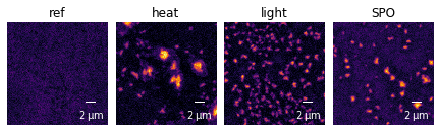

In [50]:
elmdict={}
smparr = [a for a in procDF['smp']]
for smp in smparr:
    elmdict[smp]={'CsImap':procDF[procDF['smp']==smp]['CsToI'].values[0],
                   'stepsize':procDF[procDF['smp']==smp]['stepSize'].values[0]}
    
savebool = 0
plotChannel(elmdict, elmdict.keys(), 'CsImap',[0,0.27], 'inferno',savebool)

In [25]:
usicGain = 50      # nA/V
xbicGain = 200     # nA/V
q = 1.6 * 1e-19
# electron charge
darkcts = [6500, 8000, 7340, 10060]
# dark counts
fftFreqCol = np.array([[27, 36], [25, 38], [27, 36], [20, 42]])
smpTypes = ['/CsI3-ref', '/CsI3-heat', '/CsI3-light', '/CsI3-mpp']
elm = 'select_xbic'
iodineAttnFactor = 0.3750
xbicDF = pd.DataFrame()
with h5py.File(h5filePath, 'r') as f:
    for i, smp in enumerate(smpTypes):
        elmData = []
        stepsize = np.average(np.diff(f[smp + '/chem/select_x']))
        stepsize_chem = np.average(np.diff(f[smp + '/chem/xval']))
        elmData = f[smp + '/chem'][elm][:]  # raw XBIC
        usicData = f[smp+'/chem']['usic'][:,0:-2]
        iData = np.divide(f[smp + '/chem']['I_L_quant'][:],
                          1)  # I_L map
        pbData = np.divide(f[smp + '/chem']['Pb_M_quant'][:],
                          1)  # Pb_M map
        auData = f[smp + '/chem']['Au_M_quant'][:]
        csIdata = procDF[(procDF['smp']==smp[1:])]['CsToI'].values[0]
        csIsegmap = procDF[(procDF['smp']==smp[1:])]['kmeanMap'].values[0]
        trueXBIC = np.dot(np.subtract(elmData, 0), xbicGain / 1e6)
        trueUSIC = np.dot(usicData,usicGain / 1e6)
        fftLmts = fftFreqCol[3]
        [xbic_fft, xbic_new] = removePeriodicNoise(trueXBIC, fftLmts[0],
                                                   fftLmts[1])
        tempElmDf = pd.DataFrame([[
            smp[1:], trueXBIC, iData, pbData, auData, xbic_new, trueUSIC, xbic_fft, stepsize,
            stepsize_chem,csIdata,csIsegmap
        ]],
                                 columns=[
                                     'smp', elm, 'I_L', 'Pb_M', 'Au_M',
                                     'xbic_rm_noise', 'usic','xbicFFT',
                                     'stepSize_xbic', 'stepSize_chem','CsToI','CsToI_seg'
                                 ])
        if xbicDF.empty: xbicDF = tempElmDf
        else: xbicDF = xbicDF.append(tempElmDf)

In [12]:
def attnCorrMap(authmap, elmmap, elmth, alpha, beta, lamda_i_Au, lamda_i_psk,
                lamda_o_elm_psk, lamda_o_elm_Au):
    [m, n] = elmmap.shape
    attn_corr_factor = np.empty(elmmap.shape, dtype='float')
    t_Au = np.average(authmap)
    for i in range(m):
        for j in range(n):
            attn_corr_factor[i, j] = quad(
                attenuationCorr,
                0,
                elmth,
                args=(t_Au, alpha, beta, lamda_i_Au, lamda_i_psk,
                      lamda_o_elm_psk, lamda_o_elm_Au))[0]
    return np.divide(elmmap, attn_corr_factor)

In [39]:
xbicthcorr = {}
xbicThPd = pd.DataFrame()
smpnames = xbicDF['smp']
for i, smpName in enumerate(smpnames):
    # Account for Au attenuation - using average of Au detected in the reference sample as the norminal thickness
    mapindex = i
    au_normTh = 0.08  #um
    auMap = xbicDF['Au_M'].values[mapindex]
    avgAu = np.average(auMap)
    au_th_profile = np.dot(np.divide(auMap, avgAu), au_normTh)

    # Attenuation constants
    alpha = 15
    beta = 75
    lamda_i_Au = 1.75179
    lamda_i_psk = 6.884
    lamda_o_I_psk = 3.63996
    lamda_o_I_Au = 0.271427
    lamda_o_Pb_psk = 2.0799
    lamda_o_Pb_Au = 0.198324
    I_mw = 126.9
    Pb_mw = 207.2

    # Estimate perovskite film thickness using I_L XRF map
    film_normTh = 0.5  # um
    iMap = xbicDF['I_L'].values[mapindex]
    pbMap = xbicDF['Pb_M'].values[mapindex]
    iMap_attnCorr = attnCorrMap(au_th_profile, iMap, film_normTh, alpha, beta,
                                lamda_i_Au, lamda_i_psk, lamda_o_I_psk,
                                lamda_o_I_Au)
    pbMap_attnCorr = attnCorrMap(au_th_profile, pbMap, film_normTh, alpha,
                                 beta, lamda_i_Au, lamda_i_psk, lamda_o_Pb_psk,
                                 lamda_o_Pb_Au)
    pbIMap = np.add(iMap_attnCorr, pbMap_attnCorr)
    PbtoI = np.divide(np.divide(pbMap_attnCorr, Pb_mw),
                      np.divide(iMap_attnCorr, I_mw))

    avgPbI = np.average(pbIMap)
    film_th_profile = np.dot(np.divide(pbIMap, avgPbI), film_normTh)

    # Estimate absorption in the absorber based on Au and PSK elemental signal

    [m, n] = pbIMap.shape
    smp_absrp = np.empty(pbIMap.shape, dtype='float')
    smp_cp = np.empty(pbIMap.shape, dtype='float')
    ld = 1  #um, diffusion length
    for i in range(m):
        for j in range(n):
            smp_absrp[i, j] = quad(incidentAbsorption,
                                   0,
                                   film_th_profile[i, j],
                                   args=(au_th_profile[i, j], alpha,
                                         lamda_i_Au, lamda_i_psk))[0]
            smp_cp[i, j] = quad(collectionProfile,
                                0,
                                film_th_profile[i, j],
                                args=(ld))[0]

    # Absorption corrected xbic map
    smp_absrp_resize = resizeMap(smp_absrp,
                                 xbicDF['stepSize_chem'].values[mapindex],
                                 xbicDF['stepSize_xbic'].values[mapindex])
    smp_cp_resize = resizeMap(smp_cp, xbicDF['stepSize_chem'].values[mapindex],
                              xbicDF['stepSize_xbic'].values[mapindex])

    xbicMap = xbicDF['xbic_rm_noise'].values[mapindex]
    [sel_absrp, sel_xbic] = selectMap(smp_absrp_resize, xbicMap)
    [sel_absrp, sel_usic] = selectMap(sel_absrp,
                                      xbicDF['usic'].values[mapindex])
    [sel_absrp, sel_cp] = selectMap(sel_absrp, smp_cp_resize)

    normXBIC = np.divide(np.divide(sel_xbic, sel_absrp), sel_usic)
    normXBIC_cp = np.divide(normXBIC, sel_cp)

    normUSIC = np.divide(sel_xbic, sel_usic)
    rawXBIC = sel_xbic
    film_th = resizeMap(film_th_profile,
                        xbicDF['stepSize_chem'].values[mapindex],
                        xbicDF['stepSize_xbic'].values[mapindex])
    au_resize = resizeMap(xbicDF['Au_M'].values[mapindex],
                          xbicDF['stepSize_chem'].values[mapindex],
                          xbicDF['stepSize_xbic'].values[mapindex])
    au_th_resize = resizeMap(au_th_profile,
                             xbicDF['stepSize_chem'].values[mapindex],
                             xbicDF['stepSize_xbic'].values[mapindex])
    PbtoI_resize = resizeMap(PbtoI, xbicDF['stepSize_chem'].values[mapindex],
                             xbicDF['stepSize_xbic'].values[mapindex])
    pbIMapNorm = resizeMap(np.divide(pbIMap,np.amax(pbIMap)), xbicDF['stepSize_chem'].values[mapindex],
                             xbicDF['stepSize_xbic'].values[mapindex])
    
    # Rescale Cs:I map to make it have the same pixel size as the sel_xbic
    csToImap = resizeMap(xbicDF['CsToI'].values[mapindex],xbicDF['stepSize_chem'].values[mapindex],
                             xbicDF['stepSize_xbic'].values[mapindex])
    [sel_absrp, sel_CsToI] = selectMap(sel_absrp,csToImap)
#     csToIsegmap = xbicDF['CsToI_seg'].values[mapindex]
#     if csToIsegmap is not None:
#         print(mapindex)
#         csToISegmap = resizeMap(csToIsegmap,xbicDF['stepSize_chem'].values[mapindex],
#                                 xbicDF['stepSize_xbic'].values[mapindex])
#         
#     else:
#         sel_CsToISeg=None
#     [sel_absrp, sel_CsToISeg] = selectMap(sel_absrp,csToISegmap)

    xbicthcorr[smpName] = {
        'normUSIC': normUSIC,
        'rawXBIC': rawXBIC,
        'usic': sel_usic,
        'normXBIC': normXBIC,
        'absrpProfile': sel_absrp,
        'film_th_profile': film_th,
        'stepsize': xbicDF['stepSize_xbic'].values[mapindex],
        'rawAu': au_resize,
        'au_th_profile': au_th_resize,
        'pbImap': pbIMap,
        'pbImapNorm': pbIMapNorm,
        'normXBIC_CP': normXBIC_cp,
        'PbtoI': PbtoI_resize
    }

    tempdf = pd.DataFrame([[
        smpName,normUSIC, rawXBIC, sel_usic, normXBIC, sel_absrp, film_th,
        xbicDF['stepSize_xbic'].values[mapindex], au_resize,au_th_resize, pbIMap, pbIMapNorm,
        PbtoI_resize,sel_CsToI
    ]],
                          columns=[
                              'smp','normUSIC', 'rawXBIC', 'usic', 'normXBIC',
                              'absrpProfile', 'film_th_profile', 'stepsize',
                              'rawAu', 'au_th_profile', 'PbIMap', 'pbIMapNorm', 'PbtoI','CsToI'
                          ])

    if xbicThPd.empty: xbicThPd = tempdf
    else: xbicThPd = xbicThPd.append(tempdf)
#     plotXRFmaps(xbicMap,'inferno',None)
#     plotXRFmaps(np.divide(sel_xbic,sel_absrp),'inferno',None)

In [15]:
xbicThPd

,smp,normUSIC,rawXBIC,usic,normXBIC,absrpProfile,film_th_profile,stepsize,rawAu,au_th_profile,PbIMap,PbtoI,CsToI
0,CsI3-ref,"[[0.5037396158620272, 0.5116424866345797, 0.50...","[[10.173190767360843, 10.327607520099088, 10.2...","[[20.1953359375, 20.185203125, 20.189984375, 2...","[[1.0518578354188353, 1.0721200904949046, 1.06...","[[0.47890465697909174, 0.4772249780324504, 0.4...","[[0.5234629265723446, 0.5210105810625654, 0.51...",-0.300752,"[[114.1501089529077, 111.89316171506846, 102.7...","[[0.08434819929734236, 0.08268048792004191, 0....","[[209.9127010322058, 211.46490528606577, 212.8...","[[0.19640836688432398, 0.20410917767768819, 0....","[[0.030591491357542758, 0.028072990650612202, ..."
0,CsI3-heat,"[[0.3320450611595628, 0.3618997302088095, 0.40...","[[6.664515334064189, 7.2631664268171985, 8.181...","[[20.0711171875, 20.069554687500002, 19.992576...","[[0.7284534439022331, 0.7705903190167588, 0.89...","[[0.45582193884737415, 0.46963960132613464, 0....","[[0.4945747992687742, 0.5111241077120872, 0.49...",-0.300751,"[[106.1819944461316, 110.55193270839209, 108.2...","[[0.0754624306631048, 0.07856809998903914, 0.0...","[[245.28273766685138, 246.50665705833597, 260....","[[0.1937779757288583, 0.23011848940981378, 0.1...","[[0.013932481320917497, 0.019480633981441134, ..."
0,CsI3-light,"[[0.3898371816881026, 0.38364153501152126, 0.3...","[[7.7799666251757476, 7.663584939236648, 7.829...","[[19.956964062500003, 19.9759, 19.9719, 19.970...","[[0.8465181705008789, 0.8307711636438329, 0.83...","[[0.4605183861055678, 0.46178966218427336, 0.4...","[[0.5030679930299072, 0.504206204729988, 0.512...",-0.300752,"[[117.45563269911254, 116.0701280412574, 104.0...","[[0.08595806548074439, 0.08494410559336396, 0....","[[221.78255838441964, 217.5443710468396, 219.0...","[[0.2271939749290106, 0.18867001829157162, 0.1...","[[0.010163013023170974, 0.02590056042568307, 0..."
0,CsI3-mpp,"[[0.40594346789059554, 0.39341809812409695, 0....","[[7.388344910156031, 7.160121481502266, 7.0644...","[[18.200428125000002, 18.199776562500002, 18.2...","[[0.8684799397620173, 0.834824197967352, 0.821...","[[0.46741835856546443, 0.4712586183797737, 0.4...","[[0.5085089901574982, 0.5119920410665169, 0.51...",0.300751,"[[141.43544862666545, 136.44393366134824, 148....","[[0.07829054676683453, 0.0755275305666947, 0.0...","[[280.5370475938986, 291.541245569289, 281.045...","[[0.2094509406806109, 0.23236771225703426, 0.2...","[[0.0373670614974991, 0.03713298601064409, 0.0..."


In [17]:
xbicThPd
xbicThPd.to_hdf('xbic_thickness_corr.h5',key='xbicThPd')

(0.5, 1.0)
(0.5, 1.0)
(0.5, 1.0)
(0.5, 1.0)
(0.2, 0.7)
(0.2, 0.7)
(0.2, 0.7)
(0.2, 0.7)


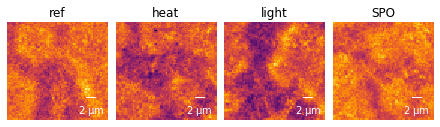

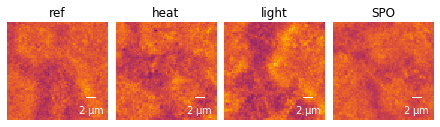

In [41]:
savebool = 1
# plotChannel(xbicThPd, xbicThPd.keys(), 'CsToI',[0,0.27], 'inferno',savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'PbtoI',[0,0.35], 'inferno',savebool)
plotChannel(xbicthcorr, xbicthcorr.keys(), 'pbImapNorm', [0.5,1], 'inferno',
            savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'absrpProfile', [0.3,0.6], 'inferno',
#             savebool)
# plotChannel(xbicthcorr,xbicthcorr.keys(),'rawXBIC',[0,13],'inferno',savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'rawAu', [70,180], 'inferno',
#             savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'au_th_profile', [0.06,0.1], 'inferno',
#             savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'usic', [16, 21], 'inferno',
#             savebool)
plotChannel(xbicthcorr, xbicthcorr.keys(), 'film_th_profile', [0.2,0.7],
            'inferno', savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'normUSIC', [0,0.6], 'inferno',
#             savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'normXBIC',[0,1.2], 'inferno', 0.4,savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'normXBIC',[0,1.2], 'inferno', 0.5,savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'normXBIC',[0,1.2], 'inferno', 0.6,savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'normXBIC',[0,1.2], 'inferno', 0.7,savebool)
# plotChannel(xbicthcorr, xbicthcorr.keys(), 'normXBIC_CP',[0,3], 'inferno',savebool)


In [59]:
a=xbicThPd['CsToI']
for x in a:
    print(np.amax(x),np.std(x))

0.06212195966692365 0.007846175464068364
0.2548124165048919 0.03263117345699566
0.22039726909545307 0.02771866981522979
0.24510181565905562 0.024263306278177528


In [52]:
(0.25+0.22+0.24)/3

0.23666666666666666